In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [5]:
print("1. Loading Data from Multiple Subjects")

# Parameters
subjects = list(range(1, 11))  # we maken nu gebruik van de eerste 10 sujects hun data
runs = [4, 8, 12]  # Motor imagery runs (left/right hand)


# Functie om data te laden van een specifieke subject
# We maken gebruik van de mne library om de data te laden en te verwerken
# De data wordt gefilterd tussen 8 en 30 Hz
# De data wordt opgedeeld in epochs van 4 seconden
# De data wordt gelabeld als linker of rechter hand motor imagery
# De data wordt gereturned als X, y en info
# X is de data in de vorm van (n_epochs, n_channels, n_times)


def load_subject_data(subject_id, runs):
    print(f"Loading data for subject {subject_id}...")
    # Download
    raw_fnames = eegbci.load_data(subject_id, runs)
    raw_files = [read_raw_edf(f, preload=True) for f in raw_fnames]
    raw = mne.concatenate_raws(raw_files)
    eegbci.standardize(raw)

    # bandpass filter (8-30 Hz, mu and beta rhythms) TODO: WAAROM 8-30 HZ?
    raw.filter(8., 30., fir_design='firwin')
    
    #  Haal de events uit de annotations
    events, event_id = mne.events_from_annotations(raw)
    
    # Making van epochs
    tmin, tmax = 0., 4. # 4 seconden epochs TODO: WAAROM 4 SECONDEN?

    # We maken een picks object om de channels te selecteren
    # We selecteren enkel de EEG channels en negeren de rest  TODO: WAAROM?
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False)
    
    # Extract epochs for left and right hand motor imagery
    # maak  een dictionary met de event id's en haal de epochs voor linker en rechter hand motor imagery
    event_dict = {'left_hand': event_id['T1'], 'right_hand': event_id['T2']}
    epochs = mne.Epochs(raw, events, event_dict, tmin, tmax, proj=True, picks=picks,
                       baseline=None, preload=True)
    
    # haal data en labels uit de epochs
    X = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
    y = epochs.events[:, 2] - event_id['T1']  # Convert event IDs to 0 and 1
    
    return X, y, epochs.info

# data loaden van de 10 mensen
# We maken een lijst van X en y voor elk subject
# We houden ook bij van welk subject elke stuk data is
X_all = []
y_all = []
subject_indices = []  # om bij te houden van wie elke stuk data is

# TODO: WAT DOET DEZE LOOP?
# We laden de data van elk subject en voegen deze toe aan de lijsten
# Als er een error optreedt bij het laden van de data voor een subject, dan wordt deze genegeerd
# We printen een error message als er een error optreedt
# We printen de shape van de gecombineerde data en labels
# We printen het aantal unieke subjects dat is opgenomen
for subject in subjects:
    try:
        X, y, info = load_subject_data(subject, runs)
        X_all.append(X)
        y_all.append(y)
        subject_indices.extend([subject] * len(y))
    except Exception as e:
        print(f"Error loading data for subject {subject}: {e}")
        continue

# combineer de data van alle subjects
X_combined = np.concatenate(X_all, axis=0)
y_combined = np.concatenate(y_all, axis=0)
subject_indices = np.array(subject_indices)

print(f"Combined data shape: {X_combined.shape}")
print(f"Combined labels shape: {y_combined.shape}")
print(f"Number of subjects included: {len(np.unique(subject_indices))}")

1. Loading Data from Multiple Subjects
Loading data for subject 1...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S003\S003R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T0', 'T1', 'T2']

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S004\S004R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S004\S004R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S005\S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T0', 'T1', 'T2']

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S006\S006R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S006\S006R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S007\S007R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S007\S007R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S008\S008R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S008\S008R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S009\S009R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T0', 'T1', 'T2']

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S010\S010R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from C:\Users\cmmon\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S010\S010R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [6]:
print("2. Preparing Data (Ignoring Time Domain)")

# om de tijdsdimentie weg te nemen nemen we het gemiddelde over de tijd.
X_avg = np.mean(X_combined, axis=2)  # shape: (n_epochs, n_channels)

# Reshape for CNN input: [samples, channels, 1]
X_reshaped = X_avg.reshape(X_avg.shape[0], X_avg.shape[1], 1)

print(f"Reshaped data (averaged over time): {X_reshaped.shape}")

# splitsing van de data en een stratification toepassen
X_train, X_test, y_train, y_test, subj_train, subj_test = train_test_split(
    X_reshaped, y_combined, subject_indices, test_size=0.2, random_state=42, stratify=y_combined
)

print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"Subjects in training set: {np.unique(subj_train)}")
print(f"Subjects in testing set: {np.unique(subj_test)}")

#  PyTorch tensors transformatie
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# aanmaak van data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


2. Preparing Data (Ignoring Time Domain)
Reshaped data (averaged over time): (450, 64, 1)
Training set: 360 samples
Testing set: 90 samples
Subjects in training set: [ 1  2  3  4  5  6  7  8  9 10]
Subjects in testing set: [ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
print("3. Building a Simple CNN Model")

# Simple CNN model
# We maken een eenvoudig CNN model met 2 convolutionele lagen en 2 lineaire lagen
# De eerste laag heeft 32 filters en de tweede laag heeft 64 filters
# De lineaire lagen hebben respectievelijk 32 en 2 units
# We gebruiken ReLU activatie en dropout voor regularisatie

# Het is een 1 dimensionale convolutie, dus we gebruiken Conv1d in plaats van Conv2d en het is
# vanzelf sprekend dat het niet goed gaat presteren, omdat we de tijdsdimentie hebben genegeerd
class SimpleCNN(nn.Module):
    def __init__(self, n_channels, n_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Simple convolutional layer
        # We gebruiken 2 convolutionele lagen met kernel size 1.
        # Kernel size staat op 1 want dit wil zeggen dat we enkel naar 1 tijdsstap kijken zonder temporele context
        # dit wil zeggen dat dit eigenlijk een 1x1 convolutie in image processing is wat eigenlijk een lineaire 
        # transformatie is dat toegepast wordt op onafhankelijk op elke tijdsstap

        # de n channels gaan van 32 naar 64, dit is een standaard manier om de n_channels te verhogen
        # we zouden ook de kernel size kunnen verhogen, maar dit is een eenvoudige manier om de n_channels te verhogen
        # volgens de literatuur is dit een goede manier om het netwerk  copmlexere spatial patterns te laten leren.

        # ReLu activatie is gebruikt voor simplicity, maar dit is een goede keuze voor de meeste problemen
        # We gebruiken geen pooling layers omdat we de tijdsdimentie hebben genegeerd.

        # We gebruiken geen padding, omdat we de tijdsdimentie hebben genegeerd.
        # We gebruiken geen batch normalization, omdat het een eenvoudig model is.

        # TODO:Voor EEG data is ELU een betere optie ipv ReLU, omdat het beter werkt met negatieve waarden en overal beter
        # met noise can omgaan in het signaal
        self.conv = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=1),
            nn.ReLU()
        )
        
        # 2 Fully connected layers
        # We gebruiken een dropout laag voor regularisatie
        # We gebruiken een dropout van 0.5, dit is een standaard waarde
        # We gebruiken een softmax laag voor de classific

        # Flattening : aangezien we de tijdsidimentie hebben samengevoegd door het gemiddelde te nemen voordat we 
        # de data in het model invoeren, hebben we een  uitvoer van 64x1x1. We moeten dit flattenen voordat we het
        # in de lineaire lagen invoeren. Dit wordt gedaan met nn.Flatten(). Dit zet het om naar een 1D tensor.

        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, n_classes)
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x



# Initialisatie van het model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# model definitie
# We maken een instantie van het model en printen de structuur
model = SimpleCNN(X_train.shape[1]).to(device)
print(model)

3. Building a Simple CNN Model
Using device: cpu
SimpleCNN(
  (conv): Sequential(
    (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (3): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [8]:
print("4. Training the Model")

# Training van het model
# Definitie  loss function em optimizer
# We gebruiken cross-entropy loss en Adam optimizer
# We trainen het model voor 50 epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters TODO: WAAROM 50 EPOCHS?
num_epochs = 50

# lijst waar alle metrics worden opgeslagen
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop TODO: ZOEK OP WAT DEZE LOOP DOET , WAAROM HET DOET WAT HET DOET EN HOE JE DAT KAN AANPASSEN.
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    # print het progress uit elke 10 epochs

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        print(f"  Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.4f}")

print("Training complete")


4. Training the Model
Epoch 10/50
  Training Loss: 0.6939, Accuracy: 0.5028
  Validation Loss: 0.6929, Accuracy: 0.5111
Epoch 20/50
  Training Loss: 0.6932, Accuracy: 0.5222
  Validation Loss: 0.6929, Accuracy: 0.5111
Epoch 30/50
  Training Loss: 0.6935, Accuracy: 0.5111
  Validation Loss: 0.6930, Accuracy: 0.5111
Epoch 40/50
  Training Loss: 0.6930, Accuracy: 0.5111
  Validation Loss: 0.6929, Accuracy: 0.5111
Epoch 50/50
  Training Loss: 0.6932, Accuracy: 0.5111
  Validation Loss: 0.6929, Accuracy: 0.5111
Training complete


5. Evaluating the Model


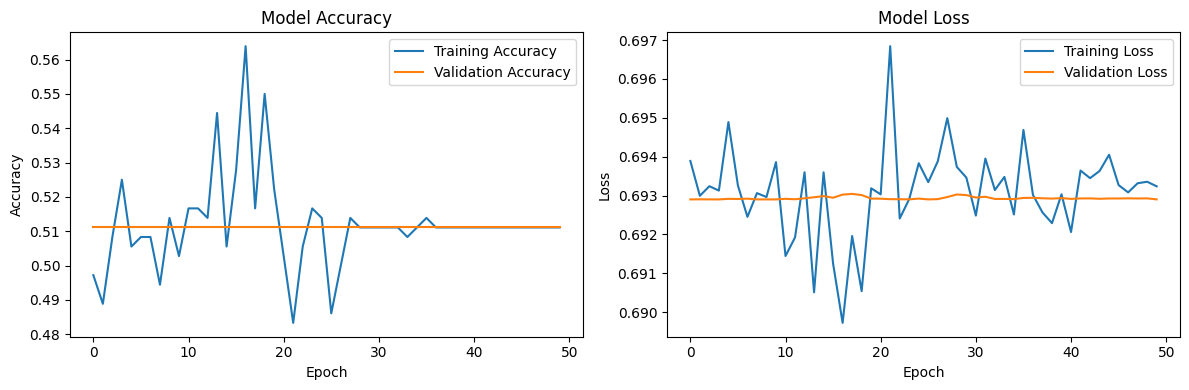

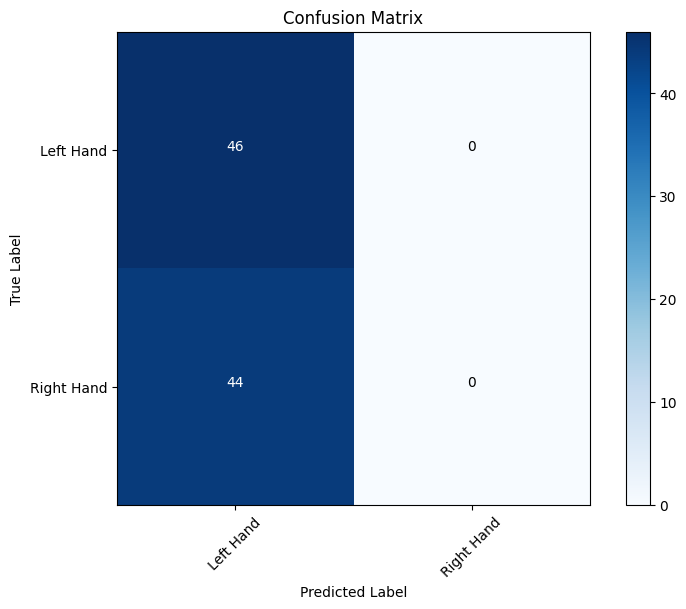


Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.51      1.00      0.68        46
  Right Hand       0.00      0.00      0.00        44

    accuracy                           0.51        90
   macro avg       0.26      0.50      0.34        90
weighted avg       0.26      0.51      0.35        90



C:\Users\cmmon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmmon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cmmon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

In [9]:
print("5. Evaluating the Model")
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(X_test_tensor.to(device))
    _, predicted = torch.max(outputs, 1)

# Convert predictions to numpy for evaluation
y_pred = predicted.cpu().numpy()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Left Hand', 'Right Hand']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

# Probleem
MODEL COLLAPSE: Model maakt altijd de zelfde predictie zonder te kijken naar de input.
Redenen:
- te hoge learning rate
- weinig model capacity
- imbalanced classes
- problemen met data preprocessing



# Verbeterde versie met aanpoassing aan de mogelijke oorzaken

In [ ]:
class_counts = np.bincount(y_train)
class_weights = torch.FloatTensor(1.0 / class_counts)
class_weights = class_weights / class_weights.sum()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Lower the learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Add learning rate scheduling
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                               factor=0.5, patience=5)

# Initialize early stopping variables
best_val_acc = 0.0
patience_counter = 0
patience = 10  # Number of epochs to wait before early stopping

# Function to monitor class-wise predictions
def print_class_predictions(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    for class_idx in range(2):
        class_mask = (labels == class_idx)
        if class_mask.sum() > 0:
            class_acc = (predicted[class_mask] == labels[class_mask]).float().mean()
            print(f"Class {class_idx} accuracy: {class_acc:.4f}")

# Training parameters
num_epochs = 50

# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = np.mean(np.array(all_predictions) == np.array(all_labels))
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Print class-wise accuracies
    if (epoch + 1) % 10 == 0:
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {epoch_loss:.4f}")
        print("Class-wise accuracies:")
        print_class_predictions(outputs, labels)
        
        # Print confusion matrix during training
        cm = confusion_matrix(all_labels, all_predictions)
        print("\nTraining Confusion Matrix:")
        print(cm)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_predictions.extend(torch.max(outputs.data, 1)[1].cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_epoch_loss = val_loss / len(test_loader.dataset)
    val_acc = np.mean(np.array(val_predictions) == np.array(val_labels))
    val_losses.append(val_epoch_loss)
    val_accs.append(val_acc)
    
    # Update learning rate based on validation accuracy
    scheduler.step(val_acc)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break
    if (epoch + 1) % 10 == 0:
        print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_acc:.4f}")
        print(f"Best validation accuracy so far: {best_val_acc:.4f}")
        
        # Print validation confusion matrix
        val_cm = confusion_matrix(val_labels, val_predictions)
        print("\nValidation Confusion Matrix:")
        print(val_cm)

# ECHT PROBLEEM 


- De 1×1-convoluties in SimpleCNN zijn te beperkt om de ruimtelijke patronen vast te leggen die het onderscheid maken tussen linker- en rechterhandverbeelding.
- Middelen over tijd verwijdert volledig de temporele dynamiek die cruciaal is voor het onderscheiden van motor imagery van de linker- en rechterhand.

6. Per-Subject Performance Analysis
Subject 1 accuracy: 0.5000 (8 samples)
Subject 2 accuracy: 0.2500 (4 samples)
Subject 3 accuracy: 0.6364 (11 samples)
Subject 4 accuracy: 0.8000 (5 samples)
Subject 5 accuracy: 0.5455 (11 samples)
Subject 6 accuracy: 0.4444 (9 samples)
Subject 7 accuracy: 0.3333 (9 samples)
Subject 8 accuracy: 0.4444 (9 samples)
Subject 9 accuracy: 0.6364 (11 samples)
Subject 10 accuracy: 0.4615 (13 samples)


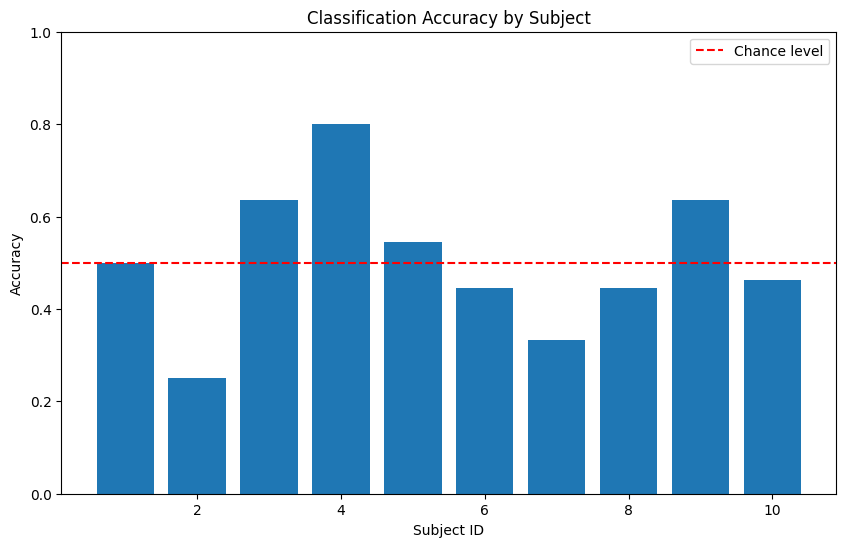

In [10]:
print("6. Per-Subject Performance Analysis")
# Analyze performance for each subject in the test set
unique_test_subjects = np.unique(subj_test)
subject_accuracies = {}

for subject in unique_test_subjects:
    # Get indices for this subject
    subject_mask = (subj_test == subject)
    
    # Get predictions and true labels for this subject
    subject_y_true = y_test[subject_mask]
    subject_y_pred = y_pred[subject_mask]
    
    # Calculate accuracy
    accuracy = np.mean(subject_y_pred == subject_y_true)
    subject_accuracies[subject] = accuracy
    
    print(f"Subject {subject} accuracy: {accuracy:.4f} ({np.sum(subject_mask)} samples)")

# Plot per-subject accuracies
plt.figure(figsize=(10, 6))
subjects = list(subject_accuracies.keys())
accuracies = list(subject_accuracies.values())

plt.bar(subjects, accuracies)
plt.axhline(y=0.5, color='r', linestyle='--', label='Chance level')
plt.xlabel('Subject ID')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy by Subject')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Wat wil dit zeggen

Nogmaals is het te zien dat accuracy gewoon slecht is.De grote variatie in nauwkeurigheid toont aan dat motor imagery-patronen sterk subject-specifiek zijn. Iedere persoon stelt zich bewegingen op een unieke manier voor, en hun EEG-signalen weerspiegelen deze individuele verschillen.

7. Leave-One-Subject-Out Cross-Validation

Leave-one-subject-out: Testing on subject 1
Accuracy on subject 1: 0.5111

Leave-one-subject-out: Testing on subject 2
Accuracy on subject 2: 0.5111

Leave-one-subject-out: Testing on subject 3
Accuracy on subject 3: 0.5111

Leave-one-subject-out: Testing on subject 4
Accuracy on subject 4: 0.5111

Leave-one-subject-out: Testing on subject 5
Accuracy on subject 5: 0.4667

Leave-one-subject-out: Testing on subject 6
Accuracy on subject 6: 0.5333

Leave-one-subject-out: Testing on subject 7
Accuracy on subject 7: 0.5111

Leave-one-subject-out: Testing on subject 8
Accuracy on subject 8: 0.4889

Leave-one-subject-out: Testing on subject 9
Accuracy on subject 9: 0.5333

Leave-one-subject-out: Testing on subject 10
Accuracy on subject 10: 0.5333


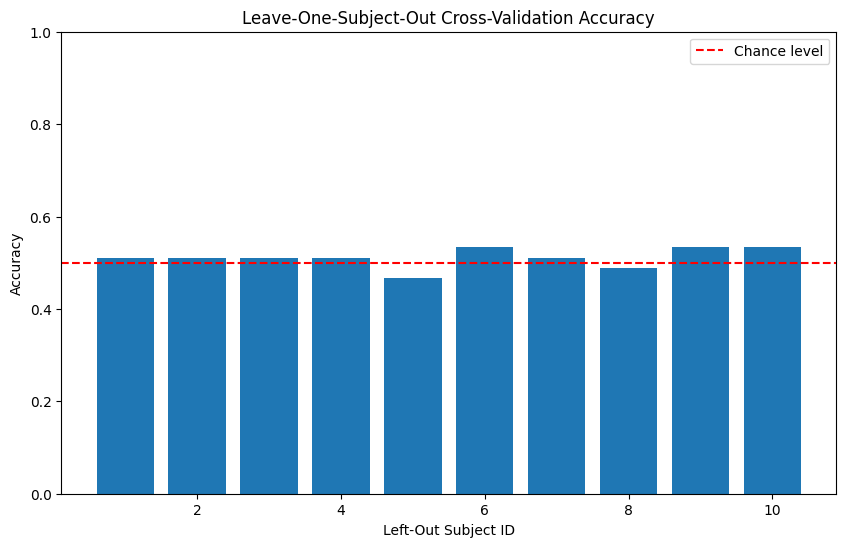

Average LOSO accuracy: 0.5111 ± 0.0199


In [11]:

print("7. Leave-One-Subject-Out Cross-Validation")
# Implement leave-one-subject-out cross-validation
# We trainen het model op alle subjects behalve 1 en testen op de overgebleven subject
# We herhalen dit voor elk subject en berekenen de gemiddelde accuracy

unique_subjects = np.unique(subject_indices)
loso_accuracies = []

for test_subject in unique_subjects:
    print(f"\nLeave-one-subject-out: Testing on subject {test_subject}")
    
    # Split data
    train_mask = (subject_indices != test_subject)
    test_mask = (subject_indices == test_subject)
    
    X_train_loso = X_reshaped[train_mask]
    y_train_loso = y_combined[train_mask]
    X_test_loso = X_reshaped[test_mask]
    y_test_loso = y_combined[test_mask]
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_loso)
    y_train_tensor = torch.LongTensor(y_train_loso)
    X_test_tensor = torch.FloatTensor(X_test_loso)
    y_test_tensor = torch.LongTensor(y_test_loso)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Initialize a new model
    model_loso = SimpleCNN(X_train_loso.shape[1]).to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_loso.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(30):  # Fewer epochs for LOSO
        model_loso.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model_loso(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluate on the left-out subject
    model_loso.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_loso(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    loso_accuracies.append(accuracy)
    print(f"Accuracy on subject {test_subject}: {accuracy:.4f}")

# Plot LOSO results
# TODO: WAT WIL DE PLOT LATEN ZIEN?
plt.figure(figsize=(10, 6))
plt.bar(unique_subjects, loso_accuracies)
plt.axhline(y=0.5, color='r', linestyle='--', label='Chance level')
plt.xlabel('Left-Out Subject ID')
plt.ylabel('Accuracy')
plt.title('Leave-One-Subject-Out Cross-Validation Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

print(f"Average LOSO accuracy: {np.mean(loso_accuracies):.4f} ± {np.std(loso_accuracies):.4f}")

Leave one out cross validation laat zien dat het eigenlijk gewoon beter is dan random choice. Dit was eigenlijk te verwachten van de confusion matrix.

# Waarom presteerd het zo slecht ??? 



We zijn eigenlijk 1 % beter dan random chance. dit  is hoogwaarschijnlijk omdat de binary classification geen rekening  houd met tijd. 


1. **Loss of Temporal Information**: By averaging over time, we're discarding valuable temporal dynamics that are crucial for motor imagery classification. Different subjects imagine movements at different speeds and times, so temporal information is important.
2. **Simple Architecture**: The 1x1 convolutions might be too simple to capture the complex spatial patterns in EEG data.


Verlies van temporele informatie: Motor imagery EEG-signalen bevatten cruciale temporele dynamieken die dit model volledig negeert. Verschillende proefpersonen stellen zich bewegingen voor op verschillende snelheden en tijdstippen.

Onvoldoende ruimtelijke modellering: De eenvoudige 1×1-convoluties vangen de complexe ruimtelijke relaties tussen EEG-kanalen niet effectief op.

Geen frequentieanalyse: Motor imagery EEG wordt gekenmerkt door specifieke frequentiebanden (mu- en beta-ritmes), die dit model zonder temporele context niet kan detecteren.

Individuele verschillen: EEG-patronen variëren aanzienlijk tussen proefpersonen, en dit eenvoudige model mist de capaciteit om generaliseerbare kenmerken over verschillende proefpersonen heen te leren.